In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import timeit
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import xesmf as xe
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from esio import EsioData as ed
from esio import ice_plot
from esio import import_data


import dask
#dask.set_options(get=dask.threaded.get)


# General plotting settings
sns.set_style('ticks')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

In [2]:
E = ed.EsioData.load()
# Directories
all_models=['rasmesrl']
runType='forecast'
updateall = False

In [3]:
# Plotting Info
runType = 'forecast'
variables = ['sic']
metrics_all = {'sic':['SIP']}
#metrics_all = {'sic':['SIP']}
updateAll = True
# Some models are terrible/have serious issues, so don't include in MME
MME_NO = ['hcmr']

In [4]:
# Target time range
valid_start = np.datetime64('2018-09-01')
valid_end = np.datetime64('2018-09-30')

In [5]:
# Define custom mod names
custom_names = {'usnavysipn':'NESM','gfdlsipn':'GFDL/NOAA','noaasipn':'NOAA CPC','uclsipn':'UCL','ukmetofficesipn':'Met Office','ecmwfsipn':'ECMWF'}

In [6]:
# Define models to plot
models_2_plot = list(E.model.keys())
models_2_plot = [x for x in models_2_plot if np.any(x not in ['piomas','MME','modcansipns_3','modcansipns_4']) ] # remove some models
models_2_plot = [x for x in models_2_plot if E.icePredicted[x]] # Only predictive models
models_2_plot

['gfdlsipn',
 'yopp',
 'ukmetofficesipn',
 'ecmwfsipn',
 'ecmwf',
 'metreofr',
 'ukmo',
 'kma',
 'ncep',
 'usnavysipn',
 'usnavyncep',
 'rasmesrl',
 'noaasipn',
 'noaasipn_ext',
 'uclsipn',
 'szapirosipn']

In [7]:
stero_grid_file = E.obs['NSIDC_0051']['grid']
obs_grid = import_data.load_grid_info(stero_grid_file, model='NSIDC')
# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)

In [8]:
# Regridding Options
method='nearest_s2d' # ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']

### Load in User submited SIP data

In [16]:
user_sip = [] # Dictionary to store user submitted (regridded) SIP data

### npssipn (RASM)

In [17]:
cmod = 'RASM'
sip_f = '/home/disk/sipn/upload/npssipn/forecast/Forecast/RASM_Sep2018_Junreportdata.nc'
# Open
ds_user = xr.open_dataset(sip_f)
#ds_user.SIP_ID.plot()
# Regrid/format to sipn
ds_user.rename({'lat':'nj', 'long':'ni','longitude':'lon','latitude':'lat'}, inplace=True);
ds_user.set_coords(['lat','lon'], inplace=True)
# Select SIP
da_in = ds_user.SIP_ID
mask = ds_user.Grid_Area.notnull()
da_in = da_in.where(mask)

In [18]:
# Calculate regridding matrix
regridder = xe.Regridder(da_in, obs_grid, method, periodic=False)
# Regrid 
da_out = regridder(da_in)
# Remove weight file
regridder.clean_weight_file() 
# da_in.plot()
# plt.figure()
# da_out.plot()

Create weight file: nearest_s2d_720x1280_304x448.nc
Remove file nearest_s2d_720x1280_304x448.nc


In [19]:
# Store in dict of user submited SIP
da_out.coords['model'] = cmod
user_sip.append(da_out)

### cansips (Mod CanSIPS)

In [20]:
cmod = 'Mod CanSIPS'
sip_f = '/home/disk/sipn/upload/ecsipn/Modified_CanSIPS_Sep2018_JuneInit_SIP.nc'
ds_user = xr.open_dataset(sip_f)
ds_user.rename({'lat':'nj', 'lon':'ni','longitude':'lon','latitude':'lat'}, inplace=True);
ds_user.set_coords(['lat','lon'], inplace=True)
# Select SIP
da_in = ds_user.sip.isel(time=0)

In [21]:
# Calculate regridding matrix
regridder = xe.Regridder(da_in, obs_grid, method, periodic=False)
# Regrid 
da_out = regridder(da_in)
# Remove weight file
regridder.clean_weight_file() 
# da_in.plot()
# plt.figure()
# da_out.plot()
# Store in dict of user submited SIP
da_out.coords['model'] = cmod
user_sip.append(da_out)

Create weight file: nearest_s2d_45x360_304x448.nc
Remove file nearest_s2d_45x360_304x448.nc


### nrlsipn (NESM)

In [23]:
cmod = 'NESM'
sip_f = '/home/disk/sipn/nicway/data/model/usnavysipn/forecast/metrics_from_nrl/NESM_Sep2018_Maydata_SIP_common.nc'
ds_user = xr.open_dataset(sip_f)
ds_user.rename({'Longitude':'lon','Latitude':'lat'}, inplace=True);
# Select SIP
da_in = ds_user.SIP.isel(MT=0)
da_in = da_in / 100 # scale to 0-1

In [24]:
# Calculate regridding matrix
regridder = xe.Regridder(da_in, obs_grid, method, periodic=False)
# Regrid 
da_out = regridder(da_in)
# Remove weight file
regridder.clean_weight_file() 
# da_in.plot()
# plt.figure()
# da_out.plot()
# Store in dict of user submited SIP
da_out.coords['model'] = cmod
print("Not adding User submited NESM here, Joe wanted us to use our own calculated one")
#user_sip.append(da_out)

Create weight file: nearest_s2d_31x360_304x448.nc
Remove file nearest_s2d_31x360_304x448.nc
Not adding User submited NESM here, Joe wanted us to use our own calculated one


In [25]:
# # Test plot
# da_in.plot()
# plt.figure()
# da_out.plot()

### Sean H.

In [26]:
cmod = 'BBGLM'
sip_f = '/home/disk/sipn/upload/seansipn/forecast/2018_it_June_vt_Sept.nc'
ds_user = xr.open_dataset(sip_f)
da_in = ds_user.mean(dim='valid_time').SIP

In [27]:
# Calculate regridding matrix
regridder = xe.Regridder(da_in, obs_grid, method, periodic=False)
# Regrid 
da_out = regridder(da_in)
# Remove weight file
regridder.clean_weight_file() 
# da_in.plot()
# plt.figure()
# da_out.plot()
# Store in dict of user submited SIP
da_out.coords['model'] = cmod
user_sip.append(da_out)

Create weight file: nearest_s2d_448x304_304x448.nc
Remove file nearest_s2d_448x304_304x448.nc


In [28]:
## Merge

In [29]:
usr_SIP = xr.concat(user_sip, dim='model')
usr_SIP = usr_SIP.rename({'nj':'x', 'ni':'y'})
usr_SIP.name = 'SIP'
usr_SIP

<xarray.DataArray 'SIP' (model: 3, x: 304, y: 448)>
array([[[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ...,
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ..., nan,  0.]],

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]]])
Coordinates:
    lon      (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 169.1 ...
    lat      (x, y) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
  * model    (model) <U11 'RASM' 'Mod CanSIPS' 'BBGLM'
Dimensions without coordinates: x, y
Attributes:
    regrid_method:  nearest_s2d

### Loop through SIPN SIC data and plot those models that have forecasts through target month
- Use most recent init_time (if multiple)
- Use monthly sept mean SIC for each ensemble member to calculate SIP

In [30]:
cyear = '2018'
cmonth = 'June'

In [31]:
for cvar in variables:
    
    # Define fig dir and make if doesn't exist
    fig_dir = os.path.join(E.fig_dir, 'model', 'SIO_Reports', cyear, cmonth)
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
       
    print("Starting plots...")

    # Loop through variable of interest + any metrics (i.e. SIP) based on that
    for metric in metrics_all[cvar]:



        MME_list = []      
    

        # For each model
        for (i, cmod) in enumerate(models_2_plot):
            print(cmod)

            # Load in Model
            model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc'], '*.nc') 

            # Check we have files 
            files = glob.glob(model_forecast)
            if not files:
                #print("Skipping model", cmod, "no forecast files found.")
                continue # Skip this model

            start_time = timeit.default_timer()
            ds_model = xr.open_mfdataset(model_forecast, 
                        chunks={'fore_time': 1, 'init_time': 1, 'nj': 304, 'ni': 448}, 
                                         concat_dim='init_time', autoclose=True, parallel=True)
            ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)
            print("Loading took  ", (timeit.default_timer() - start_time)/60, " minutes.")

            # Select var of interest (if available)
            if cvar in ds_model.variables:
#                     print('found ',cvar)
                ds_model = ds_model[cvar]
            else:
                print('cvar not found.')
                continue
                  
            # Get most recent init_time
            if cmod == 'usnavysipn': # Uses a lagged ensemble... so grab all inits and make them ensembles
                print(cmod, " uses a lagged ensemble, so using average")
                temp_init = ds_model.init_time[0].values
                ds_model = ds_model.isel(ensemble=0).rename({'init_time':'ensemble'})
                ds_model.coords['ensemble'] = np.arange(0,ds_model.ensemble.size)
                ds_model.coords['init_time'] = temp_init
            else:
                ds_model = ds_model.isel(init_time=ds_model.init_time.size-1)      
                  
            # Get Valid time
            ds_model = import_data.get_valid_time(ds_model.expand_dims('init_time'))
                  
            # Check if we have any valid times in range of target dates
            ds_model = ds_model.where((ds_model.valid_time>=valid_start) & (ds_model.valid_time<=valid_end), drop=True) 
            if ds_model.fore_time.size == 0:
                print("no fore_time found for target period.")
                continue
                 
            # Average over for_time
            ds_model = ds_model.mean(dim='fore_time')
            
            start_time = timeit.default_timer()
#                 print("Found data for model ", cmod, ". Plotting...")    
            if metric=='mean': # Calc ensemble mean
                ds_model = ds_model.mean(dim='ensemble')
            elif metric=='SIP': # Calc probability
                # Issue of some ensemble members having missing data
#                         ds_model = ds_model.where(ds_model>=0.15, other=0).mean(dim='ensemble')
                ok_ens = ((ds_model.notnull().sum(dim='x').sum(dim='y'))>0) # select ensemble members with any data
                ds_model = ((ds_model.where(ok_ens, drop=True)>=0.15) ).mean(dim='ensemble').where(ds_model.isel(ensemble=0).notnull())
            elif metric=='anomaly': # Calc anomaly in reference to mean observed 1980-2010
                ds_model = ds_model.mean(dim='ensemble') - da_obs_mean
                # Add back lat/long (get dropped because of round off differences)
                ds_model['lat'] = da_obs_mean.lat
                ds_model['lon'] = da_obs_mean.lon
            else:
                raise ValueError('metric not implemented')
            print("Calc metric took  ", (timeit.default_timer() - start_time)/60, " minutes.")

            # Build MME
            if 'ensemble' in ds_model:
                ds_model = ds_model.drop('ensemble')
            if cmod not in MME_NO: # Exclude some models (bad) from MME
                ds_model.coords['model'] = cmod
                MME_list.append(ds_model)
                print('Added ',cmod,' to MME.')

# Done with current it
print("Took ", (timeit.default_timer() - start_time)/60, " minutes.")

# Concat over all models
ds_MME = xr.concat(MME_list, dim='model')
ds_MME.name = 'SIP'

Starting plots...
gfdlsipn
Loading took   0.005536082837109765  minutes.


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calc metric took   0.02820291541672001  minutes.
Added  gfdlsipn  to MME.
yopp
Loading took   0.05310363871976733  minutes.
no fore_time found for target period.
ukmetofficesipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2187: UserWarning: Increasing number of chunks by factor of 26
  (nparts / max_parts))
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2187: UserWarning: Increasing number of chunks by factor of 28
  (nparts / max_parts))
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2187: UserWarning: Increasing number of chunks by factor of 31
  (nparts / max_parts))
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2187: UserWarning: Increasing number of chunks by factor of 30
  (nparts / max_parts))


Loading took   0.06637582221689324  minutes.


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calc metric took   0.0133032304700464  minutes.
Added  ukmetofficesipn  to MME.
ecmwfsipn
Loading took   0.26515471884825575  minutes.


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calc metric took   0.1476004533547287  minutes.
Added  ecmwfsipn  to MME.
ecmwf
Loading took   0.029326735126475493  minutes.
no fore_time found for target period.
metreofr
Loading took   0.01811154712922871  minutes.
no fore_time found for target period.
ukmo
Loading took   0.024936270752611258  minutes.
no fore_time found for target period.
kma
Loading took   0.01788314989923189  minutes.
no fore_time found for target period.
ncep
Loading took   0.03049647380442669  minutes.
no fore_time found for target period.
usnavysipn
Loading took   1.6645816351364677  minutes.
usnavysipn  uses a lagged ensemble, so using average


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calc metric took   0.08071182953814665  minutes.
Added  usnavysipn  to MME.
usnavyncep
Loading took   0.014269401893640558  minutes.
no fore_time found for target period.
rasmesrl
Loading took   1.0482866504617656  minutes.
no fore_time found for target period.
noaasipn
Loading took   0.0005402115018417438  minutes.


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calc metric took   0.008617282682098448  minutes.
Added  noaasipn  to MME.
noaasipn_ext
uclsipn
Loading took   0.039907641848549245  minutes.


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calc metric took   0.013794501754455268  minutes.
Added  uclsipn  to MME.
szapirosipn
Loading took   0.0006745967703560989  minutes.
Calc metric took   0.007575695100240409  minutes.
Added  szapirosipn  to MME.
Took  0.007588528096675873  minutes.


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [32]:
# Take mean over init_time (different models init different times. mean doesn't change values)
ds_MME = ds_MME.mean(dim='init_time')
ds_MME

<xarray.DataArray 'SIP' (model: 7, x: 304, y: 448)>
dask.array<shape=(7, 304, 448), dtype=float64, chunksize=(1, 304, 448)>
Coordinates:
    lon      (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 169.1 ...
    lat      (x, y) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
  * model    (model) <U15 'gfdlsipn' 'ukmetofficesipn' 'ecmwfsipn' ...
Dimensions without coordinates: x, y

In [35]:
# Merge user SIP with SPIN SIP
ds_SIP_All = xr.concat([ds_MME,usr_SIP], dim='model')

In [36]:
# Load into memory
ds_SIP_All.load()

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


<xarray.DataArray 'SIP' (model: 10, x: 304, y: 448)>
array([[[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       ...,

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]]])
Coordinates:
    lon      (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 169.1 ...
    lat      (x, y) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
  * model    (model) object 'gfdlsipn' 'ukmetofficesipn' 'ecmwfsipn' ...
Dimensions without coordinates: x, y

In [38]:
ds_MME_avg = ds_SIP_All.mean(dim='model')
ds_MME_std = ds_SIP_All.std(dim='model')

gfdlsipn
ukmetofficesipn
ecmwfsipn
usnavysipn
noaasipn
uclsipn
szapirosipn
RASM
Mod CanSIPS
BBGLM
saved  /home/disk/sipn/nicway/public_html/sipn/figures/model/SIO_Reports/2018/June/panArctic_SIP_forecast_2018_June.png


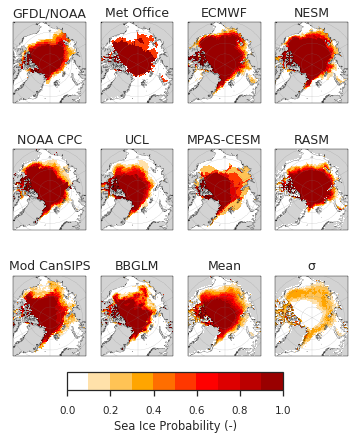

In [39]:
# Set up plotting info
if cvar=='sic':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Concentration (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='SIP':
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
        #cmap_c = plt.get_cmap('jet') 
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Probability (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='anomaly':
#                         cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("coolwarm", 9))
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'SIC Anomaly to 1980-2010 Mean'
        c_vmin = -1
        c_vmax = 1

elif cvar=='hi':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Reds_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Thickness (m)'
        c_vmin = 0
        c_vmax = None
else:
    raise ValueError("cvar not found.") 


    
def add_subplot_title(cmod, custom_names, E, ax=None):
    if cmod in custom_names:
        ax.set_title(custom_names[cmod])
    elif cmod in E.model.keys():
        ax.set_title(E.model[cmod]['model_label'])
    else:
        ax.set_title(cmod)

# New Plot
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
(f, axes) = ice_plot.multi_polar_axis(ncols=4, nrows=3, Nplots=20, extent=central_extent, central_longitude=0)

for (i, cmod) in enumerate(ds_SIP_All.model.values):
    print(cmod)
    # Plot
    add_subplot_title(cmod, custom_names, E, ax=axes[i])
    p = ds_SIP_All.sel(model=cmod).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)
    add_subplot_title(cmod, custom_names, E, ax=axes[i])


# MME Mean
i = i + 1


pmme = ds_MME_avg.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
axes[i].set_title('Mean')


# MME Standard deviation
i = i + 1


pmme = ds_MME_std.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
axes[i].set_title('σ')
    

# Make pretty
f.subplots_adjust(bottom=0.05)
# cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
cbar_ax = f.add_axes([0.25, 0.001, .5, 0.04]) #  [left, bottom, width, height] w
if p:
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
    if metric=='anomaly':
        cbar.set_ticks(np.arange(-1,1.1,0.2))
    else:
        cbar.set_ticks(np.arange(0,1.1,0.2))

# Save to file
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'.png')
f.savefig(f_out,bbox_inches='tight', dpi=200)
print("saved ", f_out)